In [1]:
''' RNN Bidireccional en Keras '''
__author__ = '@Tssp'
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
# Keras NN:
from keras.utils import to_categorical
# My utils:
from codvidutils.imageproc import map_categorical
from codvidutils.cudasession import set_session
from codvidutils import nwpic as nw

Using TensorFlow backend.


# Reading the images and preparing the dataset

In [2]:
#set_session(ngpu=1, ncpu=4)
set_session()
train_class = pd.read_csv('data/train_split_v4.csv', sep=' ', header=1, names=['image_path', 'class'])
test_class = pd.read_csv('data/test_split_v4.csv', sep=' ', header=1, names=['image_path', 'class'])
values_dict = {'pneumonia': 2, 'COVID-19': 1, 'normal': 0}
test_class['class_categorical'] = test_class['class'].apply(map_categorical, args=(values_dict,))
train_class['class_categorical'] = train_class['class'].apply(map_categorical, args=(values_dict,))

pics = []
for img in train_class['image_path'].values:
    pics.append(np.array(Image.open('data/train/' + img))[:, :,:3])
X_train = np.array(pics)
for img in test_class['image_path'].values:
    pics.append(np.array(Image.open('data/test/' + img))[:, :, :3])
X_test = np.array(pics)
print("Total number of images:", len(pics))

diseaseID_train = np.asarray(train_class["class_categorical"])
diseaseID_test = np.asarray(test_class["class_categorical"])
print('shape X: {} {},  disease_ID (Y): {} {}'.format(X_train.shape[0], X_test.shape[0], diseaseID_train.shape[0], diseaseID_test.shape[0] ))
del train_class, test_class, pics

Num GPUs Available:  2
Num CPUs Available:  7
---------Keras session created with---------
 - 2 GPUs
 - 7 CPUs


## Imablanced data

In [ ]:
counter = Counter (diseaseID_train)
print(counter)
dicto = {2: 4500, 0: 4500, 1:counter[1]}
print(dicto)
X_train = X_train.reshape(X_train.shape[0],-1)
print('X_train.shape: ', X_train.shape)
under = RandomUnderSampler(sampling_strategy =dicto)
X_train, diseaseID_train = under.fit_resample(X_train, diseaseID_train)
# summarize class distribution
print('Undersample shapes:\ndiseaseID_train.shape: {}\nX_train.shape: {}'.format(diseaseID_train.shape, X_train.shape))
X_train = X_train.reshape(X_train.shape[0],200,200,3)
X_test = X_test.reshape(X_test.shape[0],200,200,3)
print('X_train.shape: {}\nX_test.shape: {}'.format(X_train.shape, X_test.shape))

print("Normal train: ",diseaseID_train[diseaseID_train==0].shape)
print("Pneumonia train: ",diseaseID_train[diseaseID_train==2].shape)
print("COVID train: ",diseaseID_train[diseaseID_train==1].shape)
print("*******************************************************")
print("Normal test: ",diseaseID_test[diseaseID_test==0].shape)
print("Pneumonia test: ",diseaseID_test[diseaseID_test==2].shape)
print("COVID test: ",diseaseID_test[diseaseID_test==1].shape)

In [13]:
"""
News images to train 
"""
X_train_news = nw.new_pictures_arrays(X_train[diseaseID_train==1])
print(X_train_news.shape)
diseaseID_train_news = np.ones(X_train_news.shape[0])
print(diseaseID_train_news.shape)
X_train = X_train[:,10:190,10:190]
X_train = np.concatenate([X_train,X_train_news],axis=0)
diseaseID_train = np.concatenate([diseaseID_train,diseaseID_train_news],axis=0)
del X_train_news, diseaseID_train_news
print('X_train.shape: ', X_train.shape)
print('diseaseID_train.shape: ', diseaseID_train.shape)

"""
News images to test 
"""
X_test_news = nw.new_pictures_arrays(X_test[diseaseID_test==1])
print('X_test_news.shape: ', X_test_news.shape)
diseaseID_test_news = np.ones(X_test_news.shape[0])
print('diseaseID_test_news.shape: ', diseaseID_test_news.shape)
X_test = X_test[:,10:190,10:190]
X_test = np.concatenate([X_test,X_test_news],axis=0)
diseaseID_test = np.concatenate([diseaseID_test,diseaseID_test_news],axis=0)
del X_test_news, diseaseID_test_news
print('X_test.shape: ', X_test.shape)
print('diseaseID_test.shape: ', diseaseID_test.shape)

In [ ]:
Y_train = np.copy(diseaseID_train)
del diseaseID_train
Y_train[Y_train==2]=0
Y_test = np.copy(diseaseID_test)
Y_test[Y_test==2]=0

X_test = X_test/255
X_train = X_train/255

## Neural network

In [14]:
from keras.layers import Conv2D, Input, Dense, MaxPooling2D, UpSampling2D, Flatten
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam

In [15]:
input_img = Input(shape=X_train.shape[1:])
encoder = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
encoder = MaxPooling2D((2,2), padding='same')(encoder)
encoder = Conv2D(64, (3, 3), activation='relu', padding='same')(encoder)
encoder = MaxPooling2D((2,2), padding='same')(encoder)
encoder = Conv2D(128, (3, 3), activation='relu', padding='same')(encoder)
encoder = MaxPooling2D((2,2), padding='same')(encoder)
encoder = Conv2D(256, (3, 3), activation='relu', padding='same')(encoder)

decoder = Conv2D(64, (3,3), activation='relu', padding='same')(encoder)
decoder = UpSampling2D((2, 2))(decoder)
decoder = Conv2D(128, (3, 3), activation='relu', padding='same')(decoder)
decoder = UpSampling2D((2, 2))(decoder)
decoder = Conv2D(256, (3, 3), activation='relu')(decoder)
decoder = UpSampling2D((2, 2))(decoder)
decoder = Conv2D(3, (3, 3), activation='relu', padding='same')(decoder)

autoencoder = Model(input_img, decoder)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 45, 45, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 23, 23, 128)       0         
__________

In [16]:
best_model_path = 'Autoencoder_covid_v4.hdf5'
checkpoint = ModelCheckpoint(best_model_path, monitor='loss', verbose=1, save_best_only=True, mode='min')
amsgrad = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=True)
autoencoder.compile(optimizer=amsgrad, loss='mse', metrics=['acc', 'mse'])
history = autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, shuffle=False, callbacks=[checkpoint],
                          validation_data=(X_test, X_test))

Train on 9227 samples, validate on 2295 samples
Epoch 1/10
9227/9227 [==============================] - 58s 6ms/step - loss: 0.0133 - acc: 0.3658 - mean_squared_error: 0.0133 - val_loss: 0.0014 - val_acc: 0.3532 - val_mean_squared_error: 0.0014

Epoch 00001: loss improved from inf to 0.01329, saving model to Autoencoder_covid_v4.hdf5
Epoch 2/10
9227/9227 [==============================] - 55s 6ms/step - loss: 0.0013 - acc: 0.3767 - mean_squared_error: 0.0013 - val_loss: 0.0011 - val_acc: 0.2885 - val_mean_squared_error: 0.0011

Epoch 00002: loss improved from 0.01329 to 0.00133, saving model to Autoencoder_covid_v4.hdf5
Epoch 3/10
9227/9227 [==============================] - 55s 6ms/step - loss: 0.0011 - acc: 0.3634 - mean_squared_error: 0.0011 - val_loss: 9.8486e-04 - val_acc: 0.2948 - val_mean_squared_error: 9.8486e-04

Epoch 00003: loss improved from 0.00133 to 0.00111, saving model to Autoencoder_covid_v4.hdf5
Epoch 4/10
9227/9227 [==============================] - 55s 6ms/step - l

In [15]:
best_model_path = 'Autoencoder_covid_v4.hdf5'
model = load_model(best_model_path)
encoder = Model(model.layers[0].input, model.layers[6].output)
encoder_imgs = encoder.predict(X_test)
decoder_imgs = model.predict(X_test)
encoder_imgs.shape

(2195, 23, 23, 128)

Text(0.5,0,'epochs')

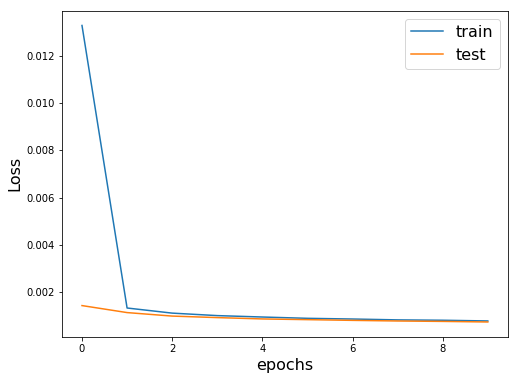

In [18]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(history.history['loss'], label='train')
ax.plot(history.history['val_loss'], label='test')
ax.legend(fontsize=16)
ax.set_ylabel('Loss', fontsize=16)
ax.set_xlabel('epochs', fontsize=16)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


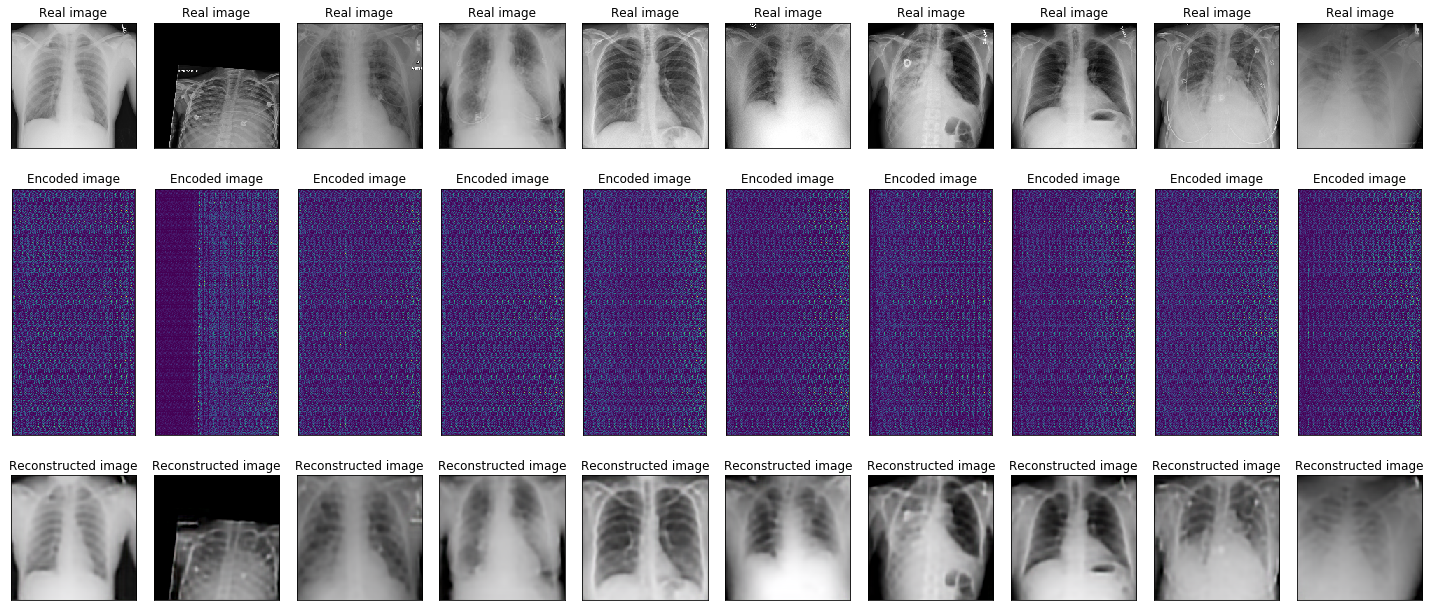

In [16]:
plt.figure(figsize=(20, 10))
for it in range(10):
    i = np.random.randint(0, len(encoder_imgs))
    ax = plt.subplot(3, 10, it+1)
    ax.imshow(X_test[i])
    plt.xticks(())
    plt.yticks(())
    ax.set_title('Real image')
    ax2 = plt.subplot(3, 10, it + 1 + 10)
    ax2.imshow(encoder_imgs[i].reshape(23*8, 23*16).T)
    plt.xticks(())
    plt.yticks(())
    ax2.set_title('Encoded image')
    ax3 = plt.subplot(3, 10, it + 1 + 2*10)
    ax3.imshow(decoder_imgs[i])
    plt.xticks(())
    plt.yticks(())
    ax3.set_title('Reconstructed image')
    plt.tight_layout()
    plt.savefig('Figures/Autoencoder_Reconstruction.png', dpi=200)